# Fonts and Word Clouds

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import string
import math
import re

First, we pick our font and make it the standard.

In [2]:
myfont = "Some Time Later"
matplotlib.font_manager._rebuild()
matplotlib.rcParams['font.sans-serif'] = myfont

font point is $\frac{1}{72}$ of an inch

Text(0, 0, 'A')

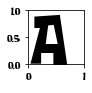

In [3]:
height = 1
width = 1

plt.figure(figsize=(width, height))
plt.axis([0, width, 0, height])
plt.text(0, 0, "A", fontsize=72)

But what about width? We can get the character glyph widths and sum them with this function. First, we have to find the font we installed.

In [4]:
fontloc = matplotlib.font_manager.findfont(myfont)
fontloc

'/Users/goadrich/Library/Fonts/Some Time Later.otf'

Then we can use this as the location in the function below.

In [5]:
# https://stackoverflow.com/questions/4190667/how-to-get-width-of-a-truetype-font-character-in-1200ths-of-an-inch-with-python
!pip install fontTools

from fontTools.ttLib import TTFont
from fontTools.ttLib.tables._c_m_a_p import CmapSubtable

font = TTFont(fontloc)
cmap = font['cmap']
t = cmap.getcmap(3,1).cmap
s = font.getGlyphSet()
units_per_em = font['head'].unitsPerEm

def getTextWidthInches(text, points):
    ratio = points / 72
    total = 0
    for c in text:
        if ord(c) in t and t[ord(c)] in s:
            total += s[t[ord(c)]].width
        else:
            total += s['.notdef'].width
    total = total * 1.3 * ratio / units_per_em;  # Why 1.3? I DON'T KNOW!!!!!!!!
    return total

Text(0, 0, 'whateverItype')

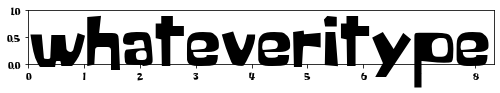

In [6]:
text = "whateverItype"

height = 1
width = getTextWidthInches(text, 72)

plt.figure(figsize=(width, height))
plt.axis([0, width, 0, height])
plt.text(0, 0, text, fontsize=72)

Let's draw 100 random words on the screen.

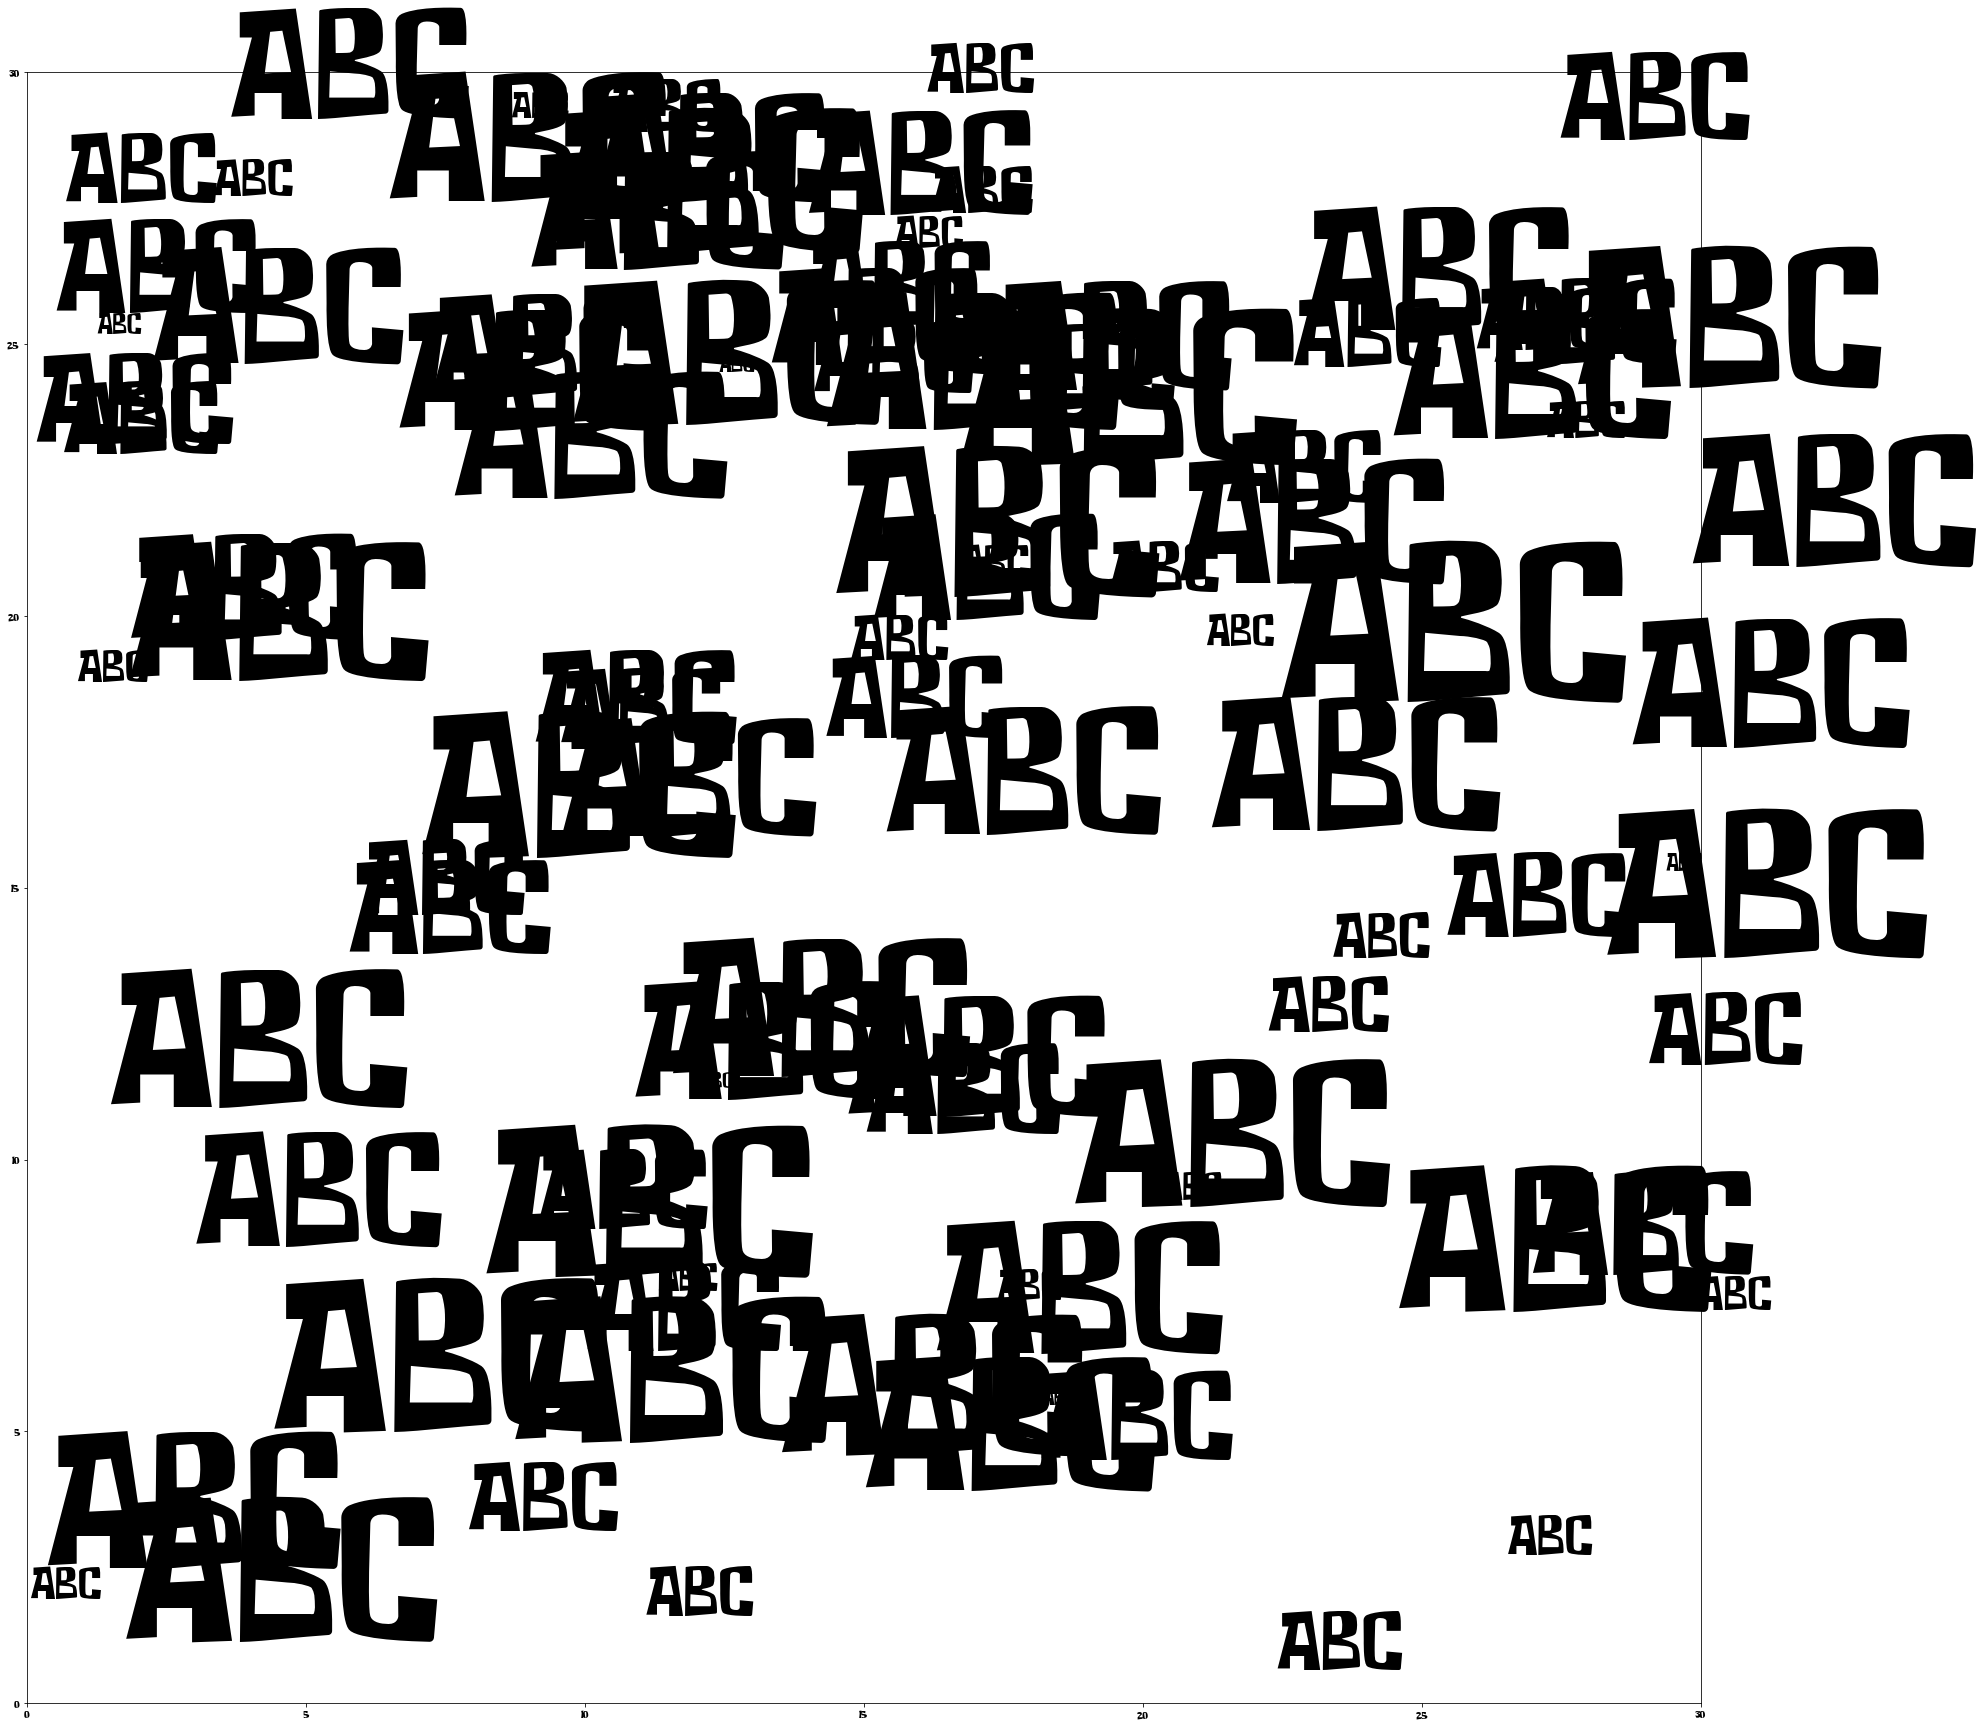

In [7]:
height = 30
width = 30

plt.figure(figsize=(width, height))
plt.axis([0, width, 0, height])
for i in range(100):
    text = "ABC"
    size = 20 + random.random() * 210
    x = random.random() * width
    y = random.random() * height
    plt.text(x, y, text, fontsize=size)

To make them stop overlapping, we need to record where they are.

We will use an object for the Word, and calculate the bounding box.

In [8]:
class Word:
    PTSIZE = 1 / 72
    
    def __init__(self, x, y, text, size):
        self.x = x
        self.y = y
        self.text = text
        self.size = size
        self.width = getTextWidthInches(self.text, self.size)
        self.height = self.size * Word.PTSIZE
        
    def right(self):
        return self.x + self.width
        
    def top(self):
        return self.y + self.height
        
    def overlap(self, other):
        # http://gamemath.com/2011/09/detecting-whether-two-boxes-overlap/
        if self.right() < other.x:
            return False
        if other.right() < self.x:
            return False
        if self.top() < other.y:
            return False
        if other.top() < self.y:
            return False
        return True

First algorithm. Keep generating new positions until they fit.

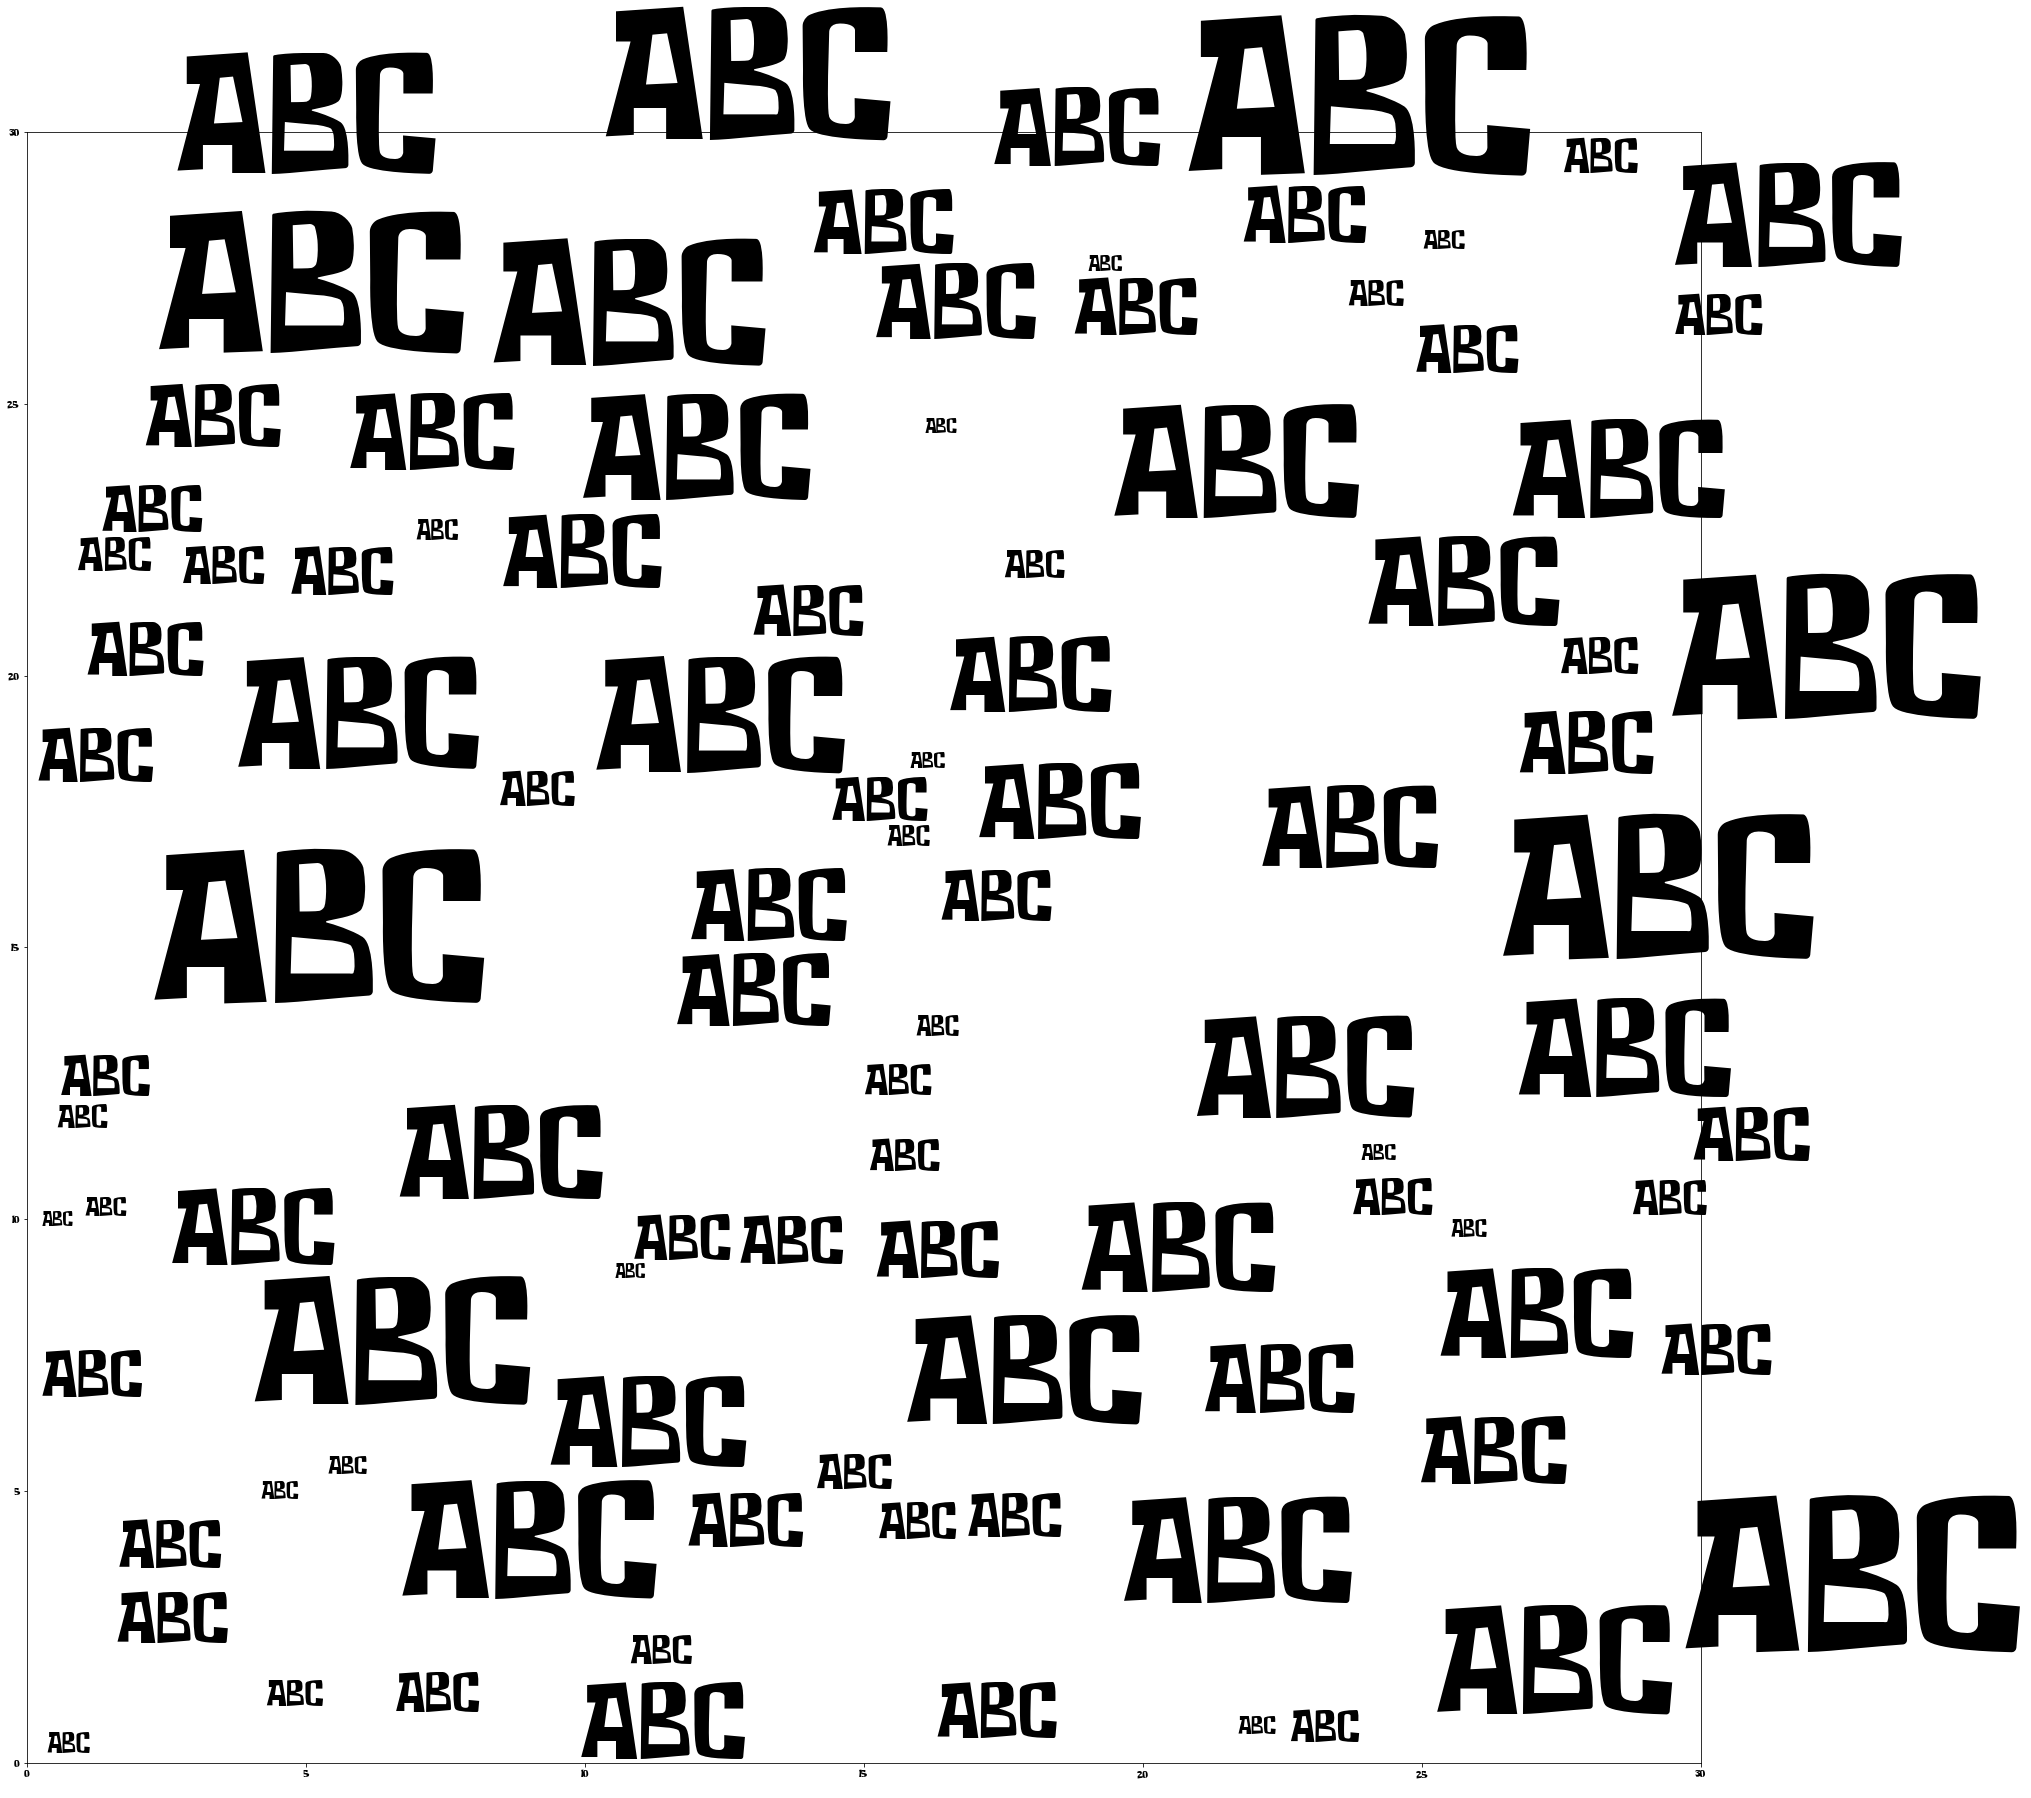

In [9]:
height = 30
width = 30

plt.figure(figsize=(width, height))
plt.axis([0, width, 0, height])

words = []
for i in range(100):
    text = "ABC"
    overlap = True
    while overlap:
        overlap = False
        
        x = random.random() * width
        y = random.random() * height
        size = 20 + random.random() * 210

        w = Word(x, y, text, size)
        for ow in words:
            if w.overlap(ow):
                overlap = True
                break
                
    words.append(w)
    
for w in words:
    plt.text(w.x, w.y, w.text, fontsize=w.size)

Let's make sure this works for variable length words.

In [10]:
def random_gibberish():
    a = random.randint(3, 13)
    s = ""
    for i in range(a):
        s += random.choice(string.ascii_uppercase + string.ascii_lowercase)
    return s

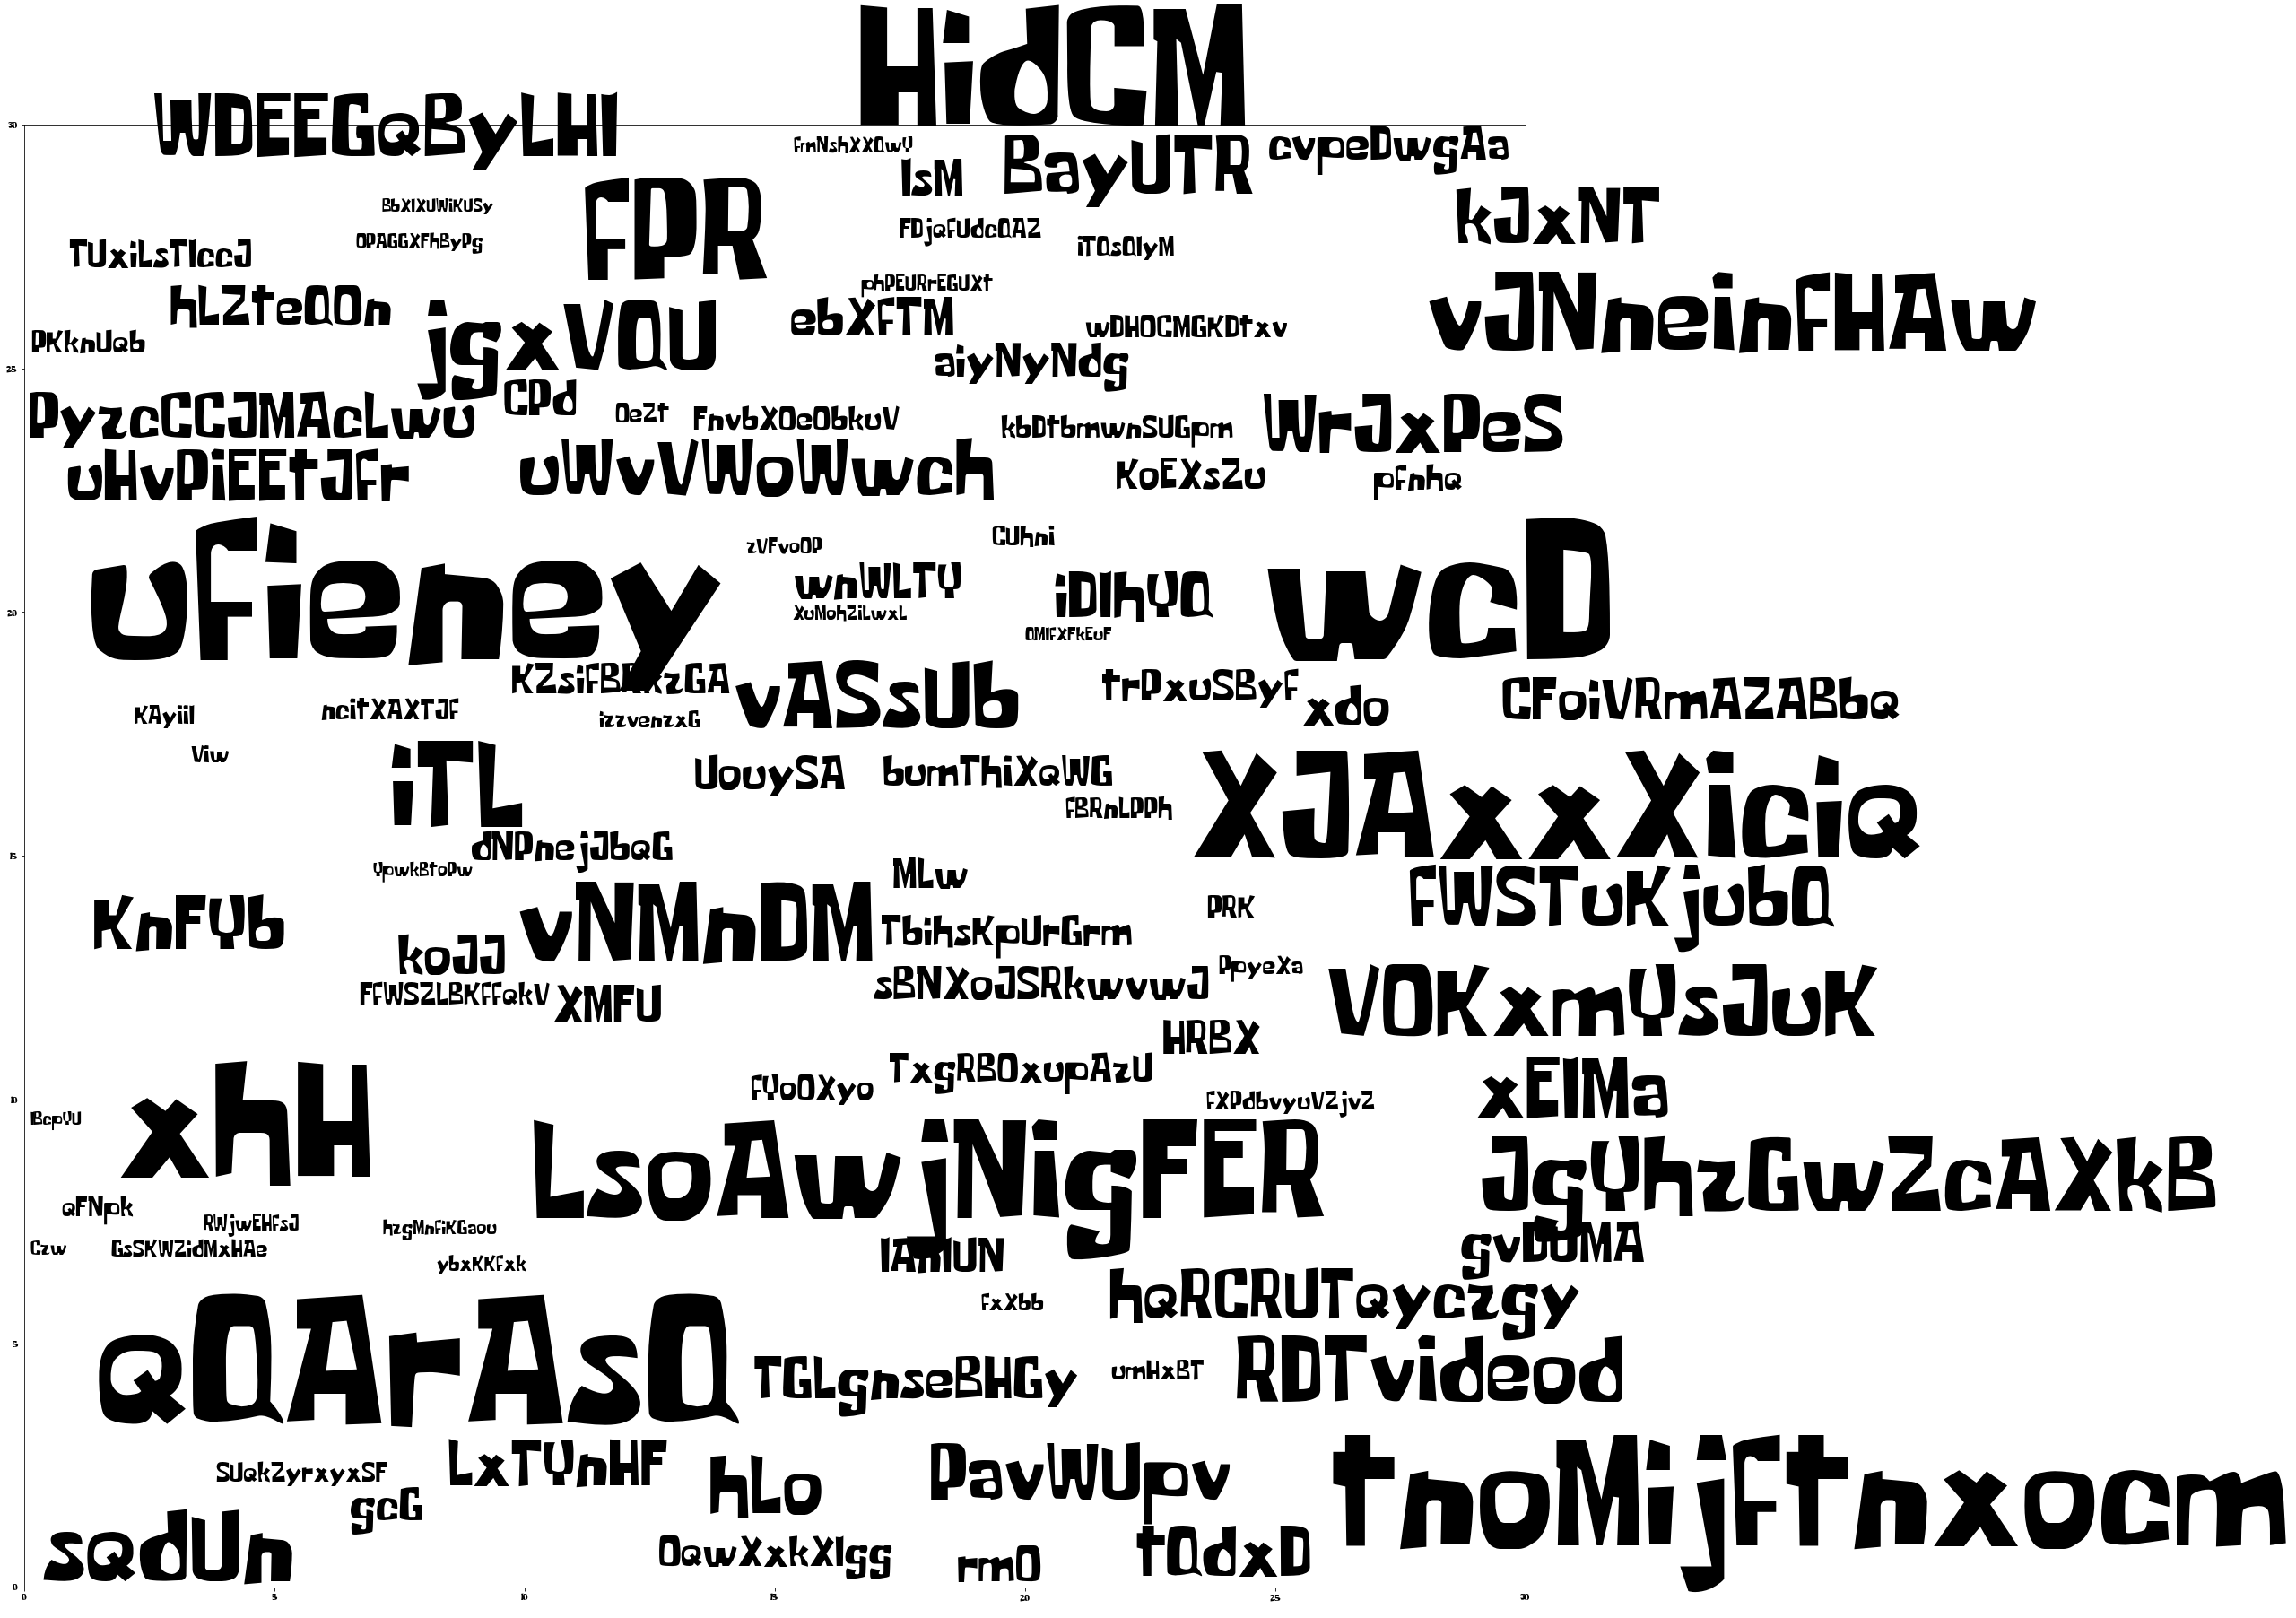

In [11]:
height = 30
width = 30

plt.figure(figsize=(width, height))
plt.axis([0, width, 0, height])
#plt.axis("off")

words = []
for i in range(100):
    text = random_gibberish()
    overlap = True
    while overlap:
        overlap = False
        
        x = random.random() * width
        y = random.random() * height
        size = 20 + random.random() * 210

        w = Word(x, y, text, size)
        for ow in words:
            if w.overlap(ow):
                overlap = True
                break
    words.append(w)

for w in words:
    plt.text(w.x, w.y, w.text, fontsize=w.size)

It works with longer strings. But two issues
* It doesn't look good
* Our sizes need to be fixed to match frequency

# Wordle Algorithm

https://www.jasondavies.com/wordcloud/about/
http://static.mrfeinberg.com/bv_ch03.pdf

use sqrt to scale word size

In decending size:

* Initially place near center line
* If overlaping, move in spiral to find open placement

How do you move in a spiral? 

Polar coordinates!

In [12]:
#https://stackoverflow.com/questions/20924085/python-conversion-between-coordinates

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

Then, increment angle and radius

/Users/goadrich/anaconda/envs/py37/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/goadrich/anaconda/envs/py37/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


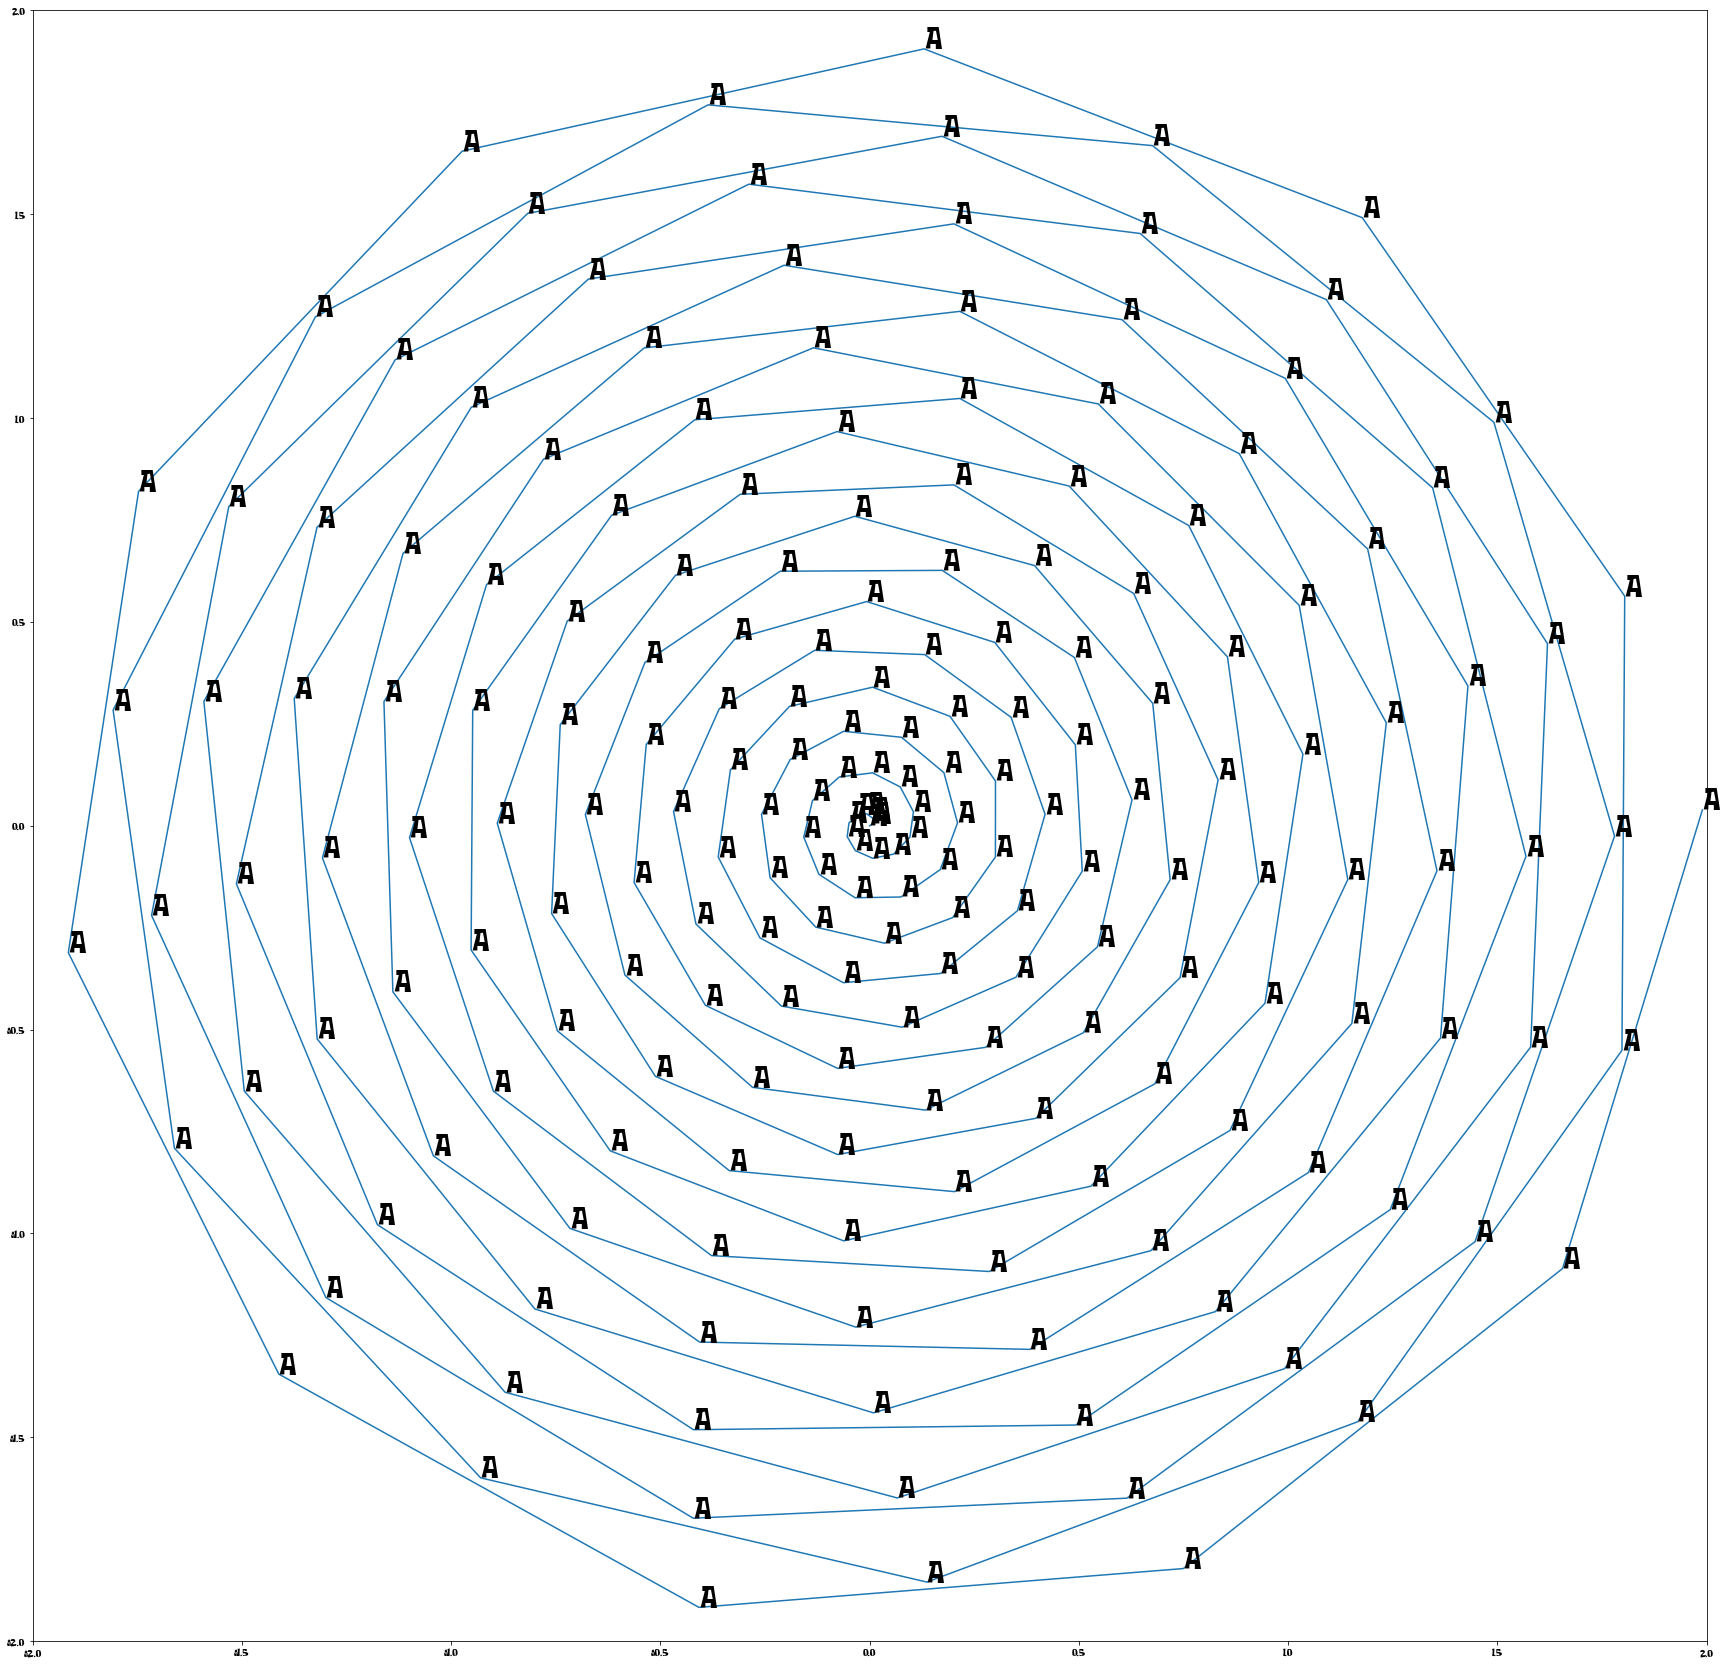

In [13]:
plt.figure(figsize=(width, height))
plt.axis([-2, 2, -2, 2])

xs = []
ys = []
r = 0
theta = 0
for i in range(200):
    x, y = pol2cart(r, theta)
    xs.append(x)
    ys.append(y)
    r += 0.01
    theta += 0.6
    plt.text(xs[-1], ys[-1], "A", fontsize=32)
    
plt.plot(xs, ys)


Add movement function to our Word object.

In [14]:
class Word:
    PTSIZE = 1 / 72
    
    def __init__(self, x, y, text, size):
        self.x = x
        self.y = y
        self.text = text
        self.size = size
        self.width = getTextWidthInches(self.text, self.size)
        self.height = self.size * Word.PTSIZE
        
        #### NEW ####
        self.initx = x
        self.inity = y
        self.r = 0
        self.theta = 0
        
    def right(self):
        return self.x + self.width
        
    def top(self):
        return self.y + self.height
        
    def overlap(self, other):
        # http://gamemath.com/2011/09/detecting-whether-two-boxes-overlap/
        if self.right() < other.x:
            return False
        if other.right() < self.x:
            return False
        if self.top() < other.y:
            return False
        if other.top() < self.y:
            return False
        return True
    
    #### NEW ####
    def move(self):
        self.r += 0.01
        self.theta += 0.3
        newx, newy = pol2cart(self.r, self.theta)
        self.x = self.initx + newx
        self.y = self.inity + newy

Now, follow the algorithm. Adding them in random size order though.

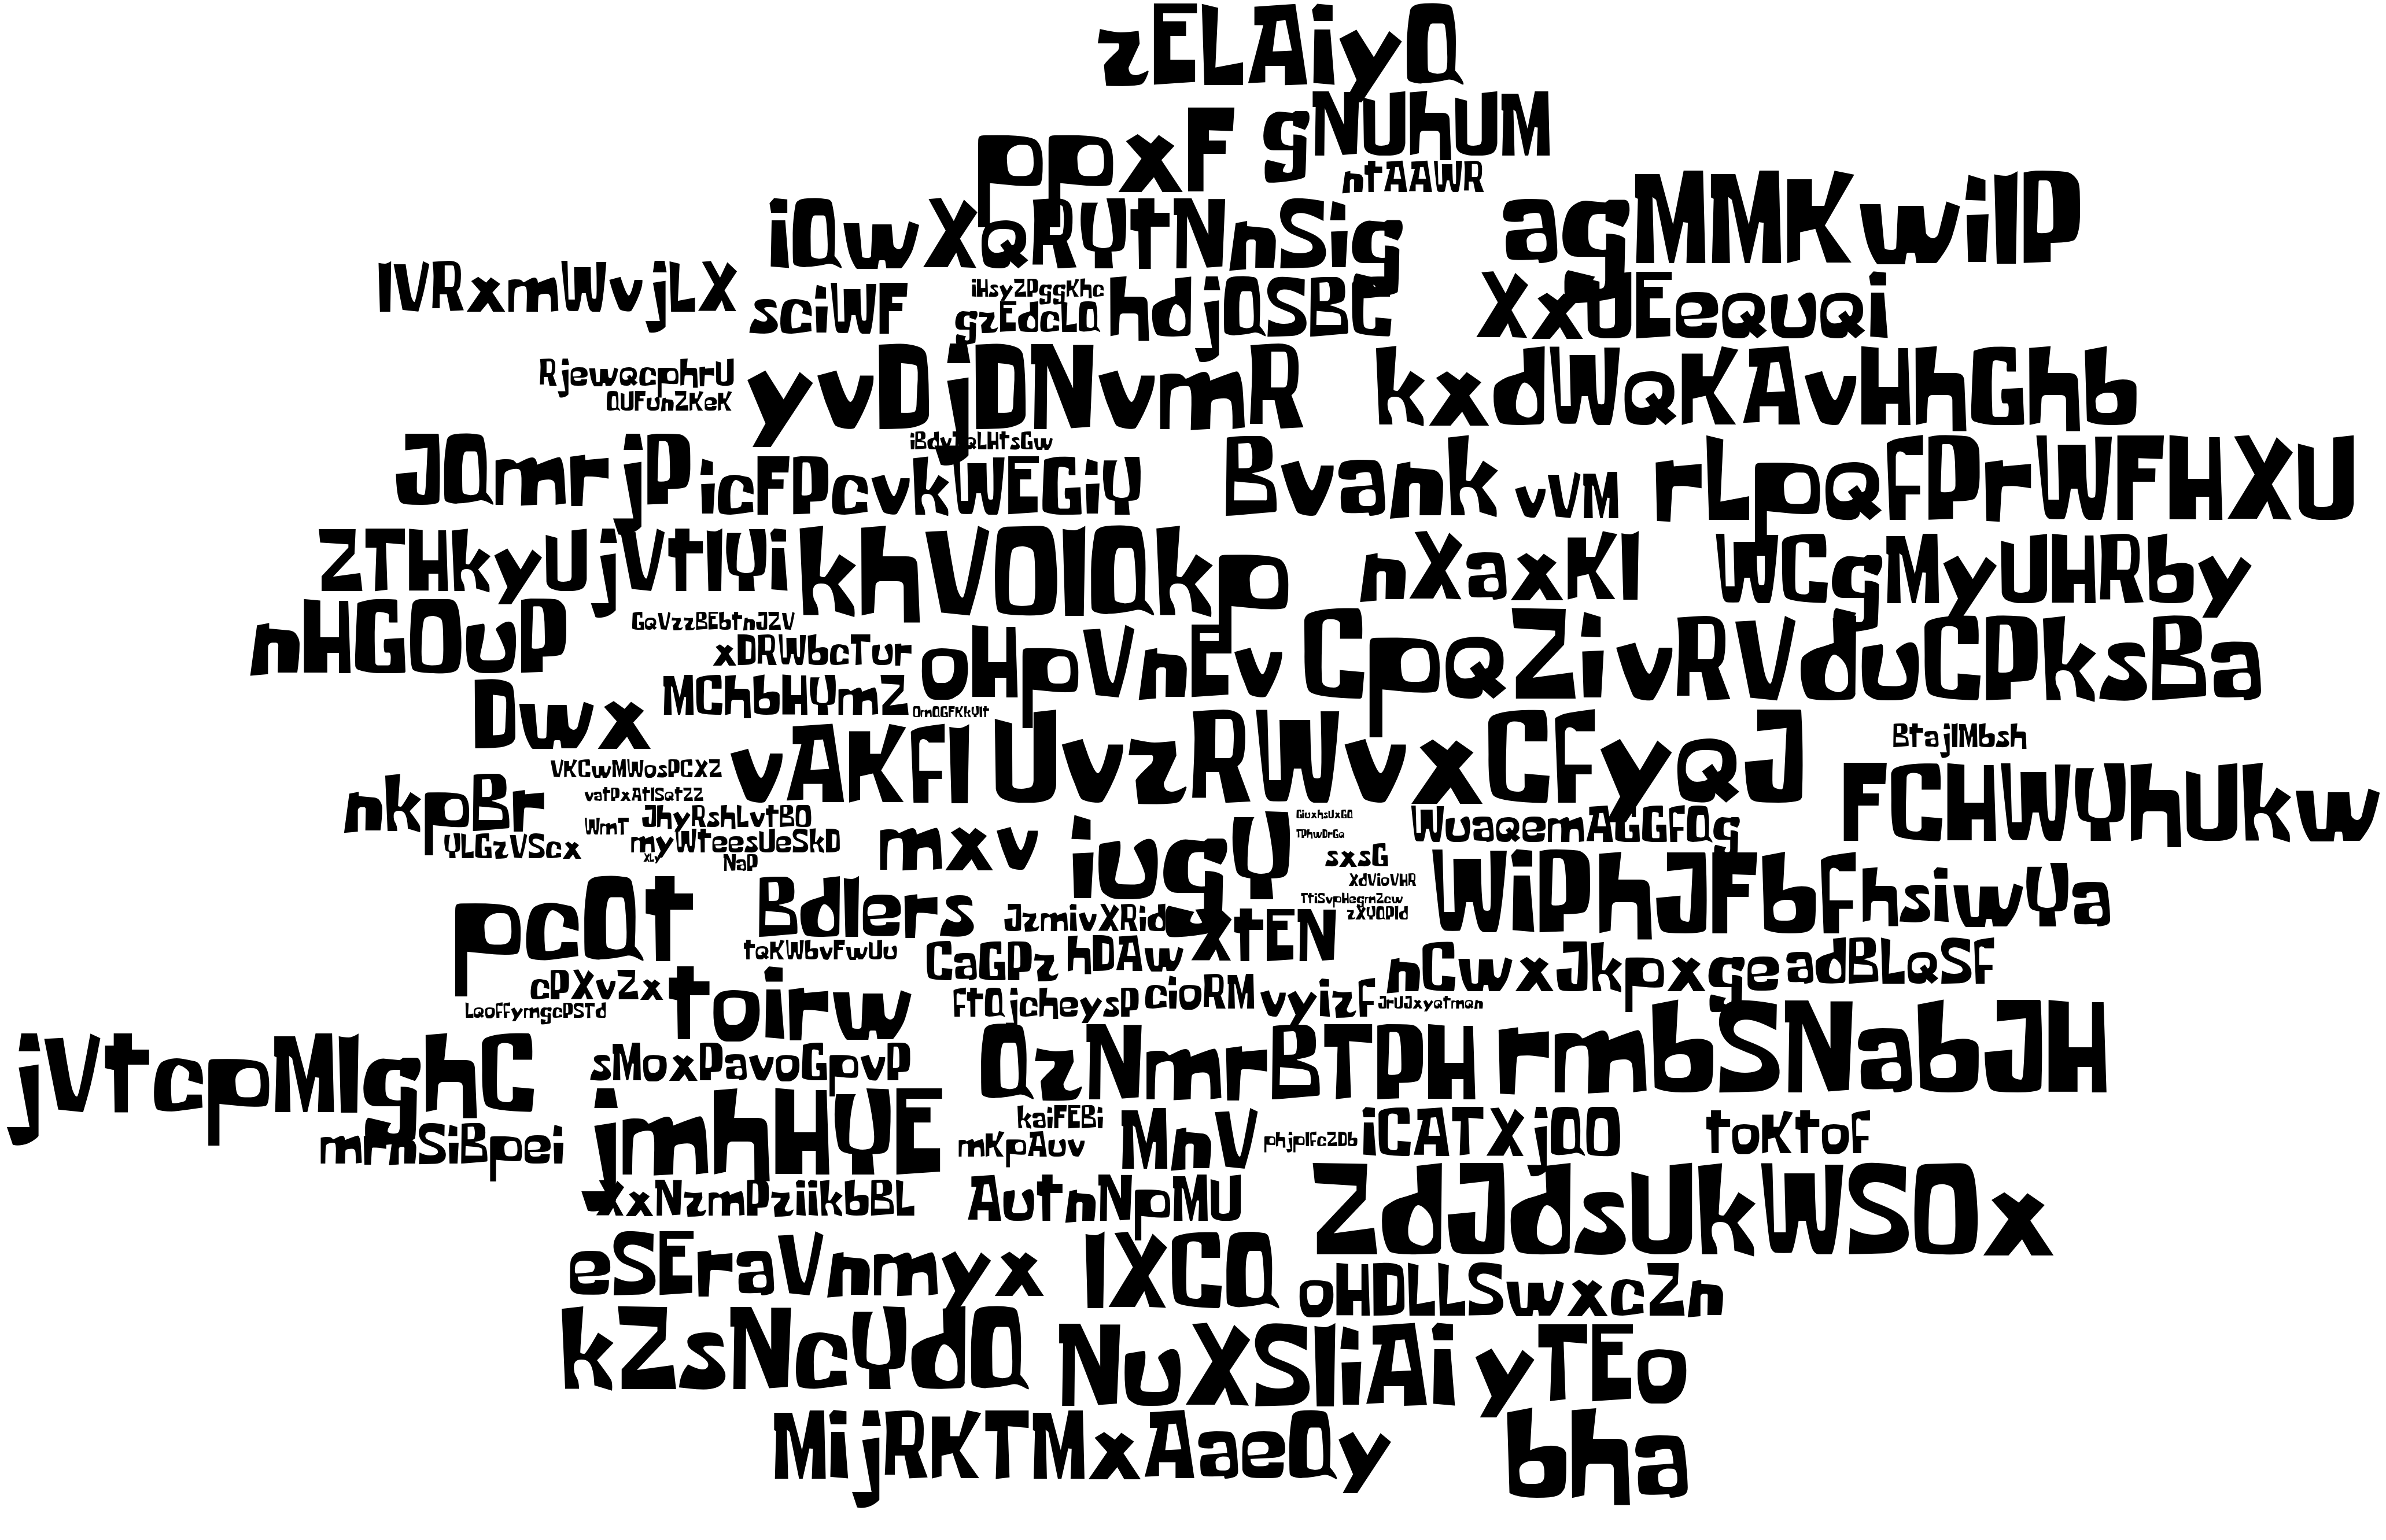

In [15]:
height = 30
width = 30

plt.figure(figsize=(width, height))
plt.axis([0, width, 0, height])
plt.axis("off")

words = []
for i in range(100):
    text = random_gibberish()
    x = random.random() * width
    y = random.random() * 2 + height / 2
    size = 20 + random.random() * 210

    w = Word(x, y, text, size)

    overlap = True
    while overlap:
        overlap = False
        
        for ow in words:
            if w.overlap(ow):
                overlap = True
                break
        if overlap:
            w.move()
    words.append(w)

for w in words:
    plt.text(w.x, w.y, w.text, fontsize=w.size)

Now get actual data from our book.

In [16]:
fopen = open("Corpus2020/Books/Eye_Of_The_World.txt")
text = fopen.read().lower().replace("\n", " ")
text = re.sub(r'[^\w\s]', '', text)
fopen.close()

d = {}
for w in text.split():
    d[w] = d.get(w, 0) + 1
    
eye_words = pd.DataFrame(list(zip(d.keys(), d.values())),
                         columns = ["word", "count"])

Remove stop words, and keep only the top 200

In [17]:
# http://xpo6.com/download-stop-word-list/
stopf = open("stop-word-list.txt")
stoppers = set(stopf.read().split())
stopf.close()

eye_words = eye_words[[w not in stoppers for w in eye_words["word"]]]
eye_words_sorted = eye_words.sort_values("count", ascending = False)

top_200 = eye_words_sorted[:200].copy()
top_200["sqrt"] = 15 * np.sqrt(top_200["count"] - (top_200["count"].min() - 1))
freqs = list(zip(top_200["word"], top_200["sqrt"]))
freqs

[('rand', 640.6246951218786),
 ('mat', 445.7297387431088),
 ('moiraine', 385.9404099080582),
 ('eyes', 363.73066958946424),
 ('time', 349.53540593193134),
 ('perrin', 339.74254958718376),
 ('just', 336.74916480965476),
 ('sedai', 333.39166156339303),
 ('man', 331.7001658124397),
 ('way', 330.68111527572904),
 ('aes', 326.5731158561586),
 ('head', 318.5514087239295),
 ('egwene', 313.5681744055031),
 ('know', 301.4962686336267),
 ('light', 297.7414986191881),
 ('lan', 291.6333314283537),
 ('dark', 291.247317584214),
 ('face', 289.30952282978865),
 ('away', 287.74989139876317),
 ('thought', 279.8213715926645),
 ('looked', 277.803887661782),
 ('hand', 266.64583251946766),
 ('trollocs', 266.64583251946766),
 ('men', 260.24027359346206),
 ('look', 257.1964229922337),
 ('long', 253.229145242012),
 ('people', 246.0182920028509),
 ('think', 245.10201957552286),
 ('come', 238.589605808803),
 ('came', 228.47319317591726),
 ('nynaeve', 225.49944567559362),
 ('right', 225.49944567559362),
 ('thom',

Time to spiral out the cloud

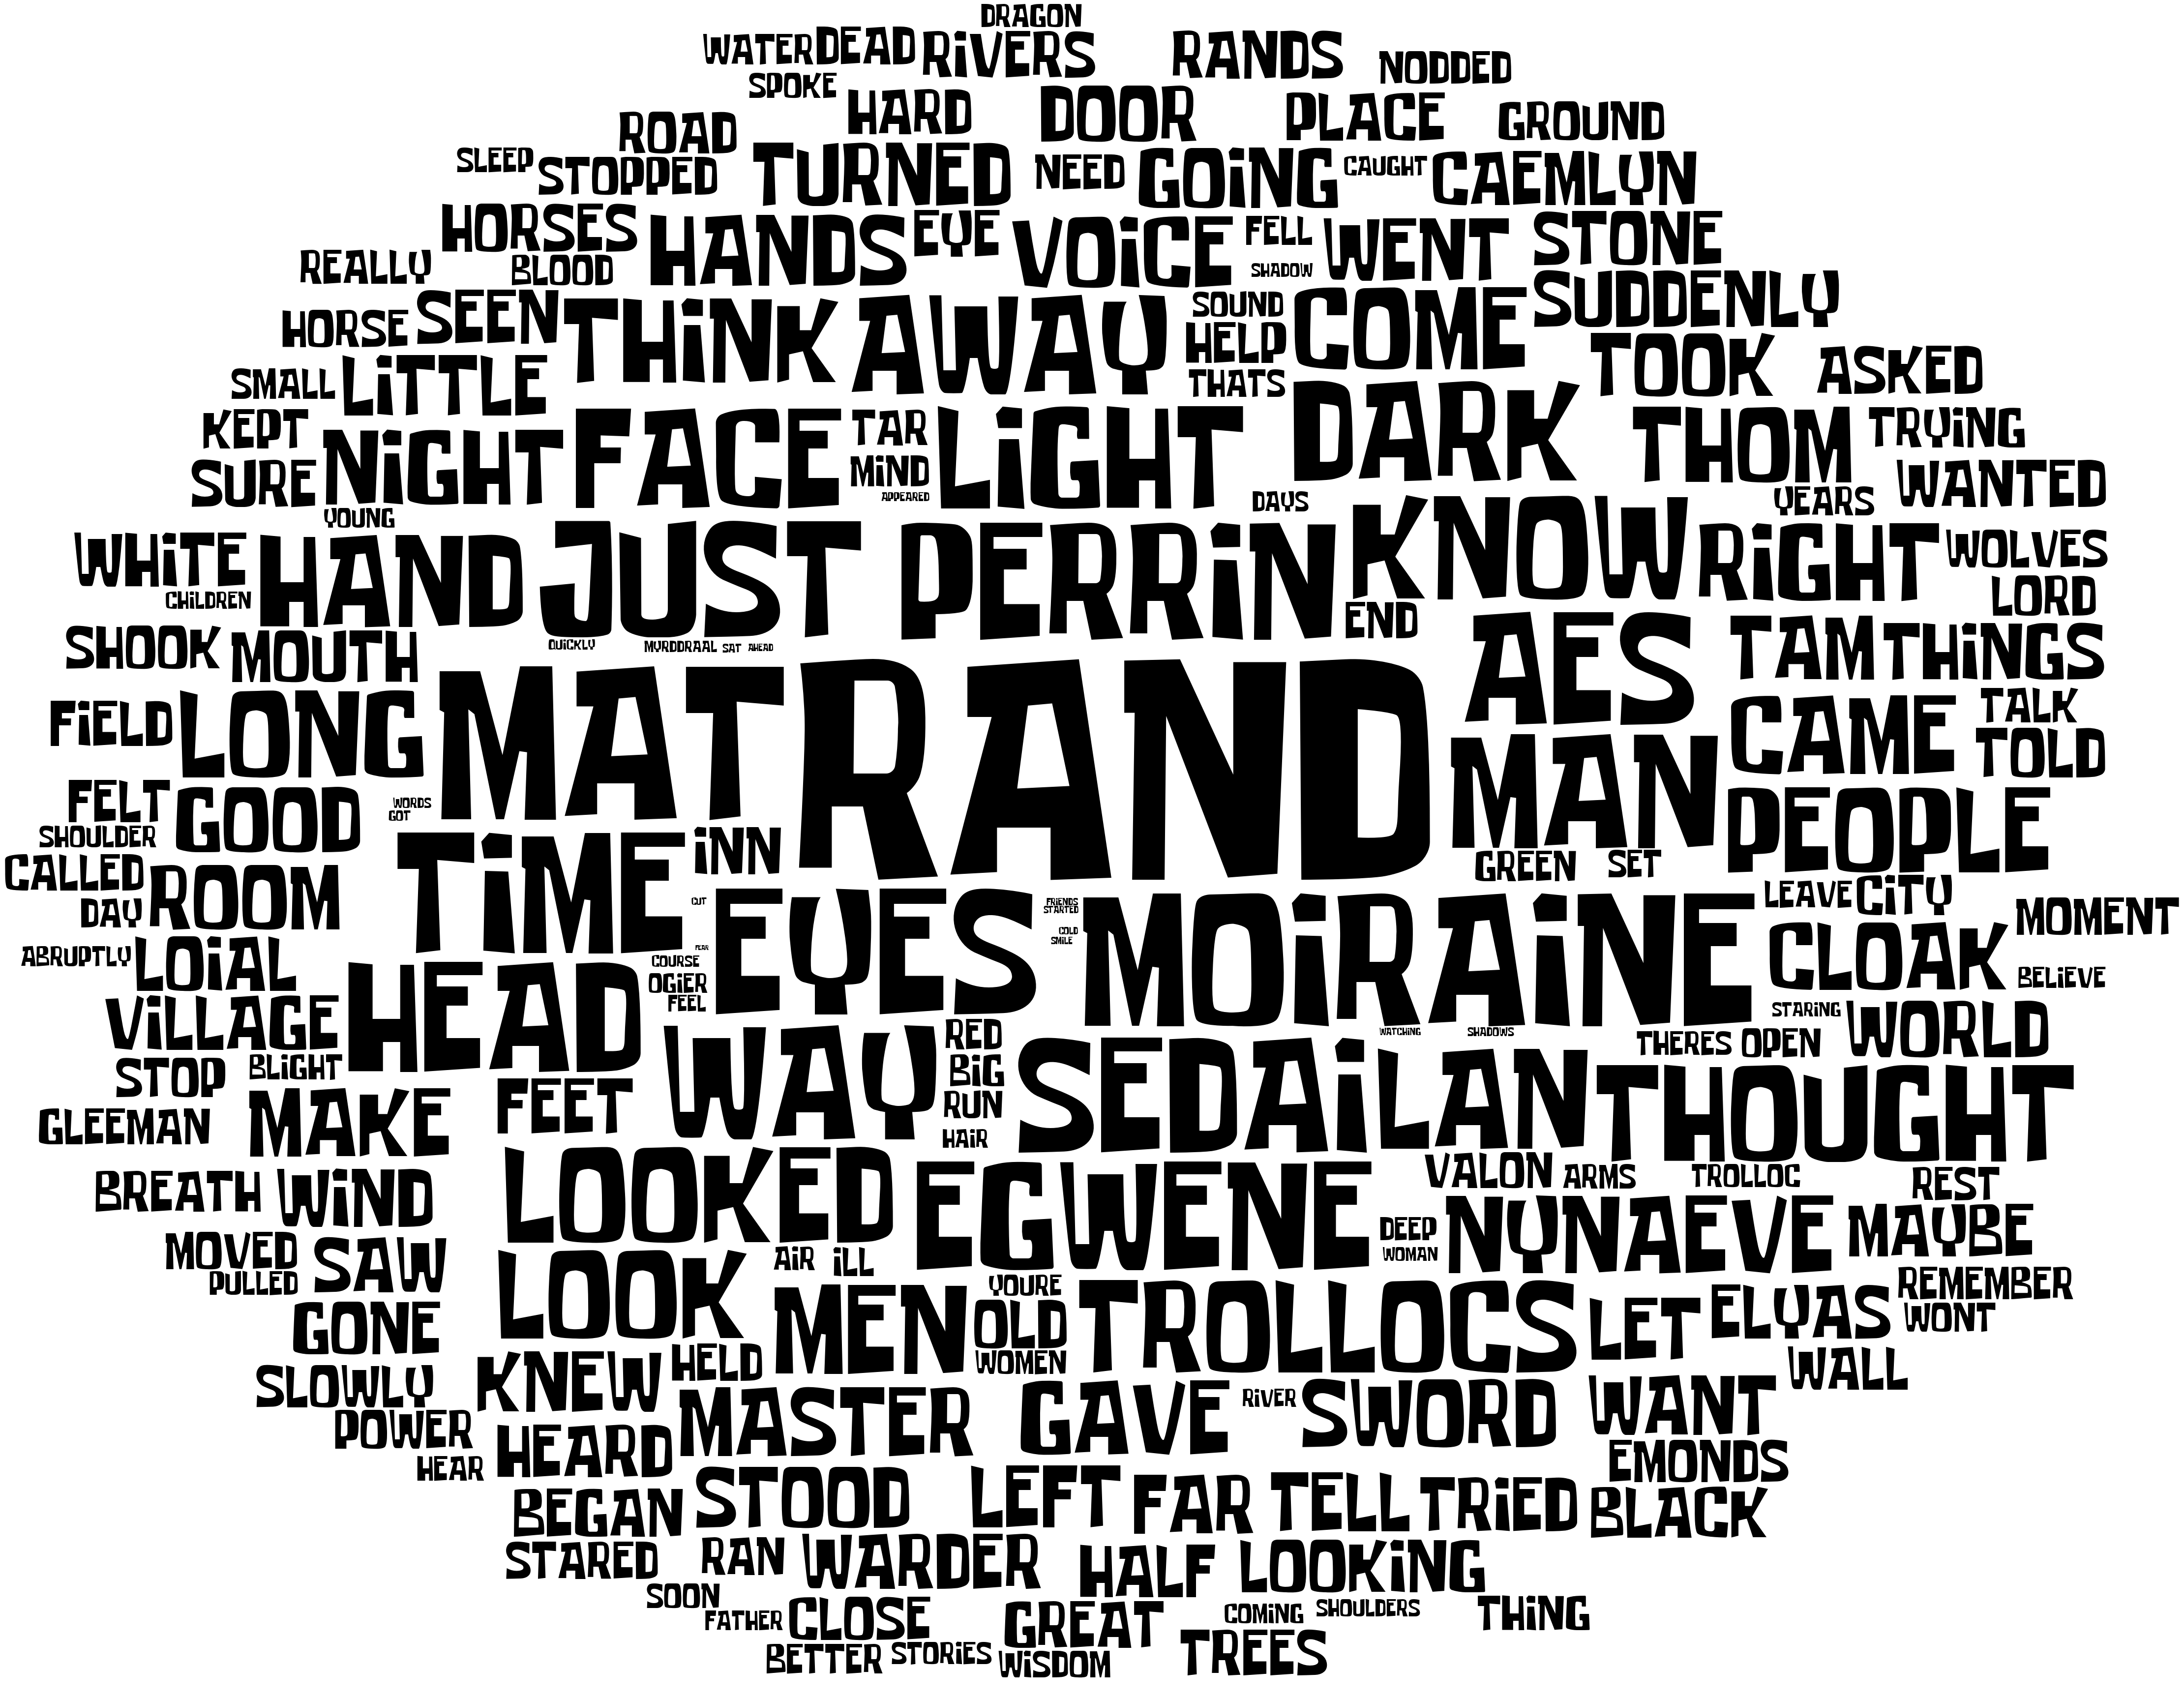

In [18]:
height = 30
width = 30

plt.figure(figsize=(width, height))
plt.axis([0, width, 0, height])
plt.axis("off")

words = []
for row in top_200.itertuples():
    x = random.random() * width
    y = random.random() * 2 + height / 2
    w = Word(x, y, row.word.upper(), row.sqrt)
    
    overlap = True
    while overlap:
        overlap = False
        for j in range(len(words)):
            ow = words[j]
            if w.overlap(ow):
                overlap = True
                break
        if overlap:
            w.move()
    words.append(w)

for w in words:
    plt.text(w.x, w.y, w.text, fontsize=w.size)

Getting closer in plotnine...

In [19]:
wordlist = [[w.x, w.y, w.text, w.height ** 2, w.size] for w in words[:200]]


In [20]:
cloud_data = pd.DataFrame(wordlist, columns=["x", "y", "word", "size", "points"])

In [21]:
cloud_data[:10]

x          y      word       size      points
0   9.031749  15.507304      RAND  79.166667  640.624695
1  -3.997383  17.756184       MAT  38.324653  445.729739
2  19.488482  10.006358  MOIRAINE  28.732639  385.940410
3   6.086195  10.445463      EYES  25.520833  363.730670
4  -5.497516  12.742639      TIME  23.567708  349.535406
5  12.864718  24.480602    PERRIN  22.265625  339.742550
6  -0.293569  24.556736      JUST  21.875000  336.749165
7  17.159844   5.289744     SEDAI  21.440972  333.391662
8  32.915950  16.673203       MAN  21.223958  331.700166
9   4.212036   5.788535       WAY  21.093750  330.681115

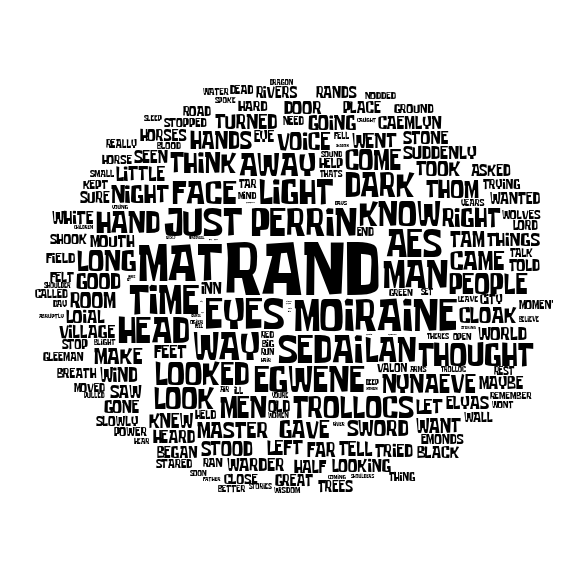

<ggplot: (294455141)>

In [22]:
from plotnine import *
ggplot(cloud_data, aes(x = "x", y = "y")) + \
geom_text(aes(label="word", size="size"), show_legend=False, hjust="left", vjust="baseline", family=myfont) + \
scale_size(range=[.01, (cloud_data["points"].max()-90) / 10]) + theme_void() + \
theme(figure_size=(7, 7), aspect_ratio=1) + xlim(cloud_data["x"].min(), 55) + ylim(cloud_data["x"].min(), 55)

In [23]:
#wc.save(filename="testing.png", height=5, width=7, units = 'in', dpi=300)